In [1]:
pip install pca

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 26.0.1
[notice] To update, run: C:\Users\silvi\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import warnings
#from yellowbrick.cluster import KElbowVisualizer
import numpy as np
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_samples, silhouette_score
from scipy.cluster import hierarchy
from scipy import stats
import logging, sys
logging.disable(sys.maxsize)
#https://erdogant.github.io/pca
from pca import pca
import statsmodels.formula.api as smf
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier


Import Data

In [5]:
import pandas as pd
akuna_data = pd.read_csv("data/akuna_data.csv",)

print("DataFrame: akuna_data")
akuna_data.head(8)

DataFrame: akuna_data


,Submission ID,Respondent ID,Submitted at,In che lingua preferisci svolgere questo sondaggio? - \r\nIn which language would you prefer to take the survey?,Hai mai acquistato delle scarpe da calcio?,Qual è il tuo genere?,Che lavoro fai?,Da dove provieni?,Quanti anni hai?,"Di solito, in che ruolo giochi?",Quante volte ti capita di giocare a calcio al mese?,Su quale tipologia di campo giochi più spesso?,Quanto hai pagato l'ultimo paio di scarpe da calcio che hai acquistato?,"E al momento dell'acquisto, preferisci...",Peso della scarpa,Morbidezza del materiale,Aderenza al piede\r\n,Durabilità,Popolarità del brand,Capacità di controllo e sensibilità con la palla,Vestibilità facilitata (ex. assenza di lacci),Ampia scelta di colorazioni,"Quanto sei d'accordo con la seguente affermazione: ""Preferisco spendere di più per avere una qualità migliore""","Hai mai sentito parlare del brand ""Akuna - Cinquestelle 1911""?",Artigianalità,Durabilità (2),Popolarità,Performance,Qualità,Artigianalità (2),Durabilità (3),Popolarità (2),Performance (2),Qualità (2),Artigianalità (3),Durabilità (4),Popolarità (3),Performance (3),Qualità (3),Artigianalità (4),...,Durability\r\n,Brand Reputation,Ball control and responsiveness\r\n,Ease of fit (i.e. laceless design)\r\n,Wide range of color option,How much do you agree with the following statement: ‘I prefer to spend more to get better quality'.,"Have you ever heard of the brand ""Akuna - Cinquestelle 1911""?",Craftsmanship,Durability,Popularity,Performance (6),Quality,Craftsmanship (2),Durability (2),Popularity (2),Performance (7),Quality (2),Craftsmanship (3),Durability (3),Popularity (3),Performance (8),Quality (3),Craftsmanship (4),Durability (4),Popularity (4),Performance (9),Quality (4),Craftsmanship (5),Durability (5),Popularity (5),Performance (10),Quality (5),At what price would the product seem so low in quality that you would no longer consider buying it?\r\n,At what price would the product start to seem like a very good deal?\r\n,At what price would you start to consider the product too expensive?\r\n,At what price would the product be so expensive that you would no longer consider buying it?\r\n,At what price would the product seem so low in quality that you would no longer consider buying it?\r\n (2),At what price would the product start to seem like a very good deal?\r\n (2),At what price would you start to consider the product too expensive?\r\n (2),At what price would the product be so expensive that you would no longer consider buying it?\r\n (2)
0,rjXaBGX,PdANzXP,2026-02-05 14:27:37,Italiano,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,jaK66l4,yPlbJQp,2026-02-05 14:29:56,English,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.0,5.0,5.0,5.0,2.0,5.0,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35.0,50.0,80.0,100.0,35.0,50.0,80.0,100.0
2,44ZJJyr,WOA6zzN,2026-02-05 14:31:37,Italiano,Sì,Maschio,Dipendente,Puglia,30.0,Centrocampista,Meno di tre,Sintetico,Meno di 80€,recarti in negozio,3.0,3.0,5.0,5.0,2.0,2.0,2.0,1.0,2.0,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ZjxEEMz,zxKAYZq,2026-02-05 14:32:21,English,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5.0,4.0,4.0,2.0,1.0,4.0,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.0,25.0,75.0,

Segmentation
Import Segmentation Data

Dataset Info

In [6]:

akuna_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117 entries, 0 to 116
Columns: 110 entries, Submission ID to At what price would the product be so expensive that you would no longer consider buying it?
 (2)
dtypes: float64(86), object(24)
memory usage: 100.7+ KB


In [7]:
ita_indices = range(14, 23)
eng_indices = range(67, 85)

clean_names = [
    "Boot weight", "Softness of material", "Foot Fit", "Durability", 
    "Brand Reputation", "Ball control", "Ease of fit", "Color options", "Quality Preference"
]
akuna_segmentation_data = pd.DataFrame()

for i in range(len(clean_names)):
    ita_col_name = akuna_data.columns[ita_indices[i]]
    eng_col_name = akuna_data.columns[eng_indices[i]]
    akuna_segmentation_data[clean_names[i]] = akuna_data[eng_col_name].combine_first(akuna_data[ita_col_name])

akuna_segmentation_data.dropna(inplace=True)
print(akuna_segmentation_data.head())

   Boot weight  Softness of material  ...  Color options  Quality Preference
1          2.0                   2.0  ...            2.0                 5.0
2          3.0                   3.0  ...            1.0                 2.0
3          2.0                   4.0  ...            1.0                 4.0
5          2.0                   3.0  ...            1.0                 5.0
6          3.0                   1.0  ...            1.0                 4.0

[5 rows x 9 columns]


dataset description

In [8]:
akuna_segmentation_data.describe().style.format("{:.1f}")

,Boot weight,Softness of material,Foot Fit,Durability,Brand Reputation,Ball control,Ease of fit,Color options,Quality Preference
count,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0
mean,3.0,3.9,4.5,4.1,2.4,3.9,2.4,1.9,3.8
std,1.0,1.0,0.7,0.9,1.2,1.2,1.3,1.1,1.1
min,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0
25%,2.0,3.0,4.0,4.0,1.0,3.0,1.0,1.0,3.0
50%,3.0,4.0,5.0,4.0,2.0,4.0,2.0,2.0,4.0
75%,4.0,5.0,5.0,5.0,3.0,5.0,3.0,3.0,5.0
max,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0


clusering

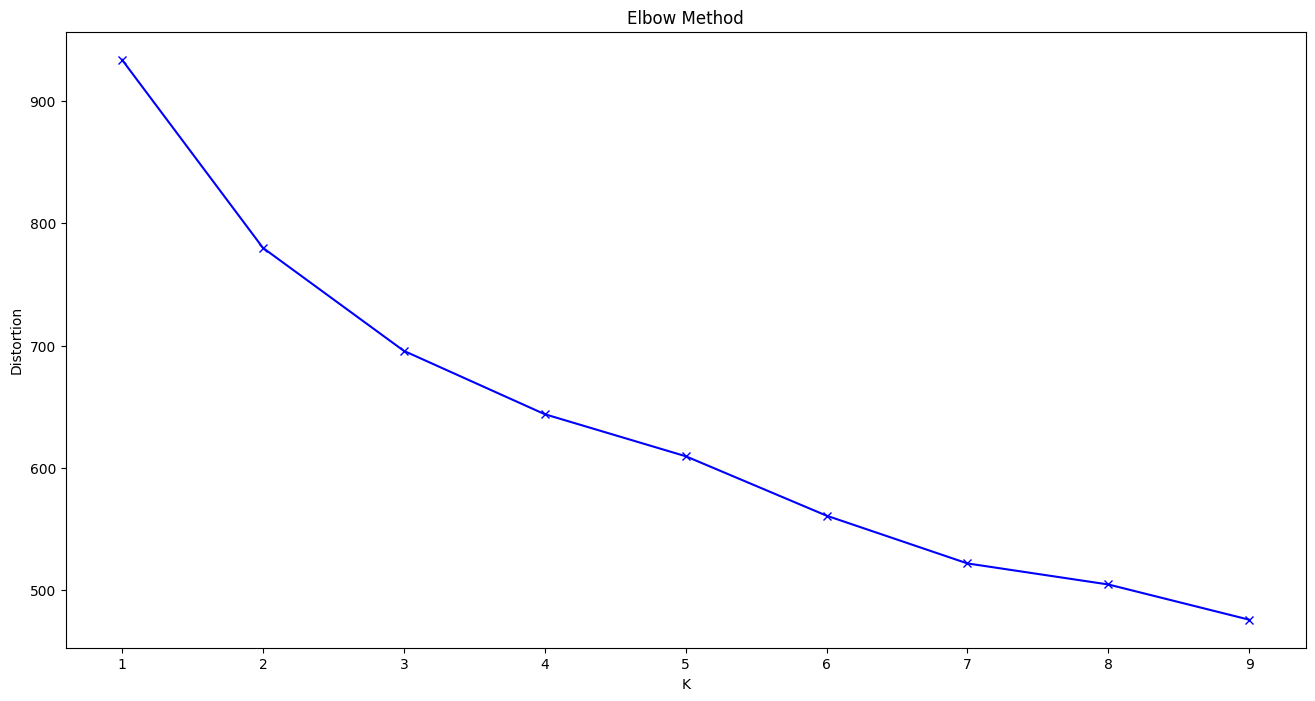

In [9]:
warnings.filterwarnings("ignore")

distortions = [KMeans(n_clusters=K).fit(akuna_segmentation_data).inertia_ for K in range(1,10)]
    
plt.figure(figsize=(16,8))
plt.plot(range(1,10), distortions, 'bx-')
plt.xlabel('K'); plt.ylabel('Distortion'); plt.title('Elbow Method');

In [ ]:
model = KMeans()
visualizer = KElbowVisualizer(model,timings=False)
visualizer.fit(akuna_segmentation_data)
visualizer.show();

In [ ]:
visualizer = KElbowVisualizer(model,metric='silhouette',timings=False)
visualizer.fit(akuna_segmentation_data)
visualizer.show();

Silhouette Analysis

For n_clusters = 2 The average silhouette_score is : 0.13835851547348088
For n_clusters = 3 The average silhouette_score is : 0.11328688189084188
For n_clusters = 4 The average silhouette_score is : 0.10499159336892136
For n_clusters = 5 The average silhouette_score is : 0.09712960111931923


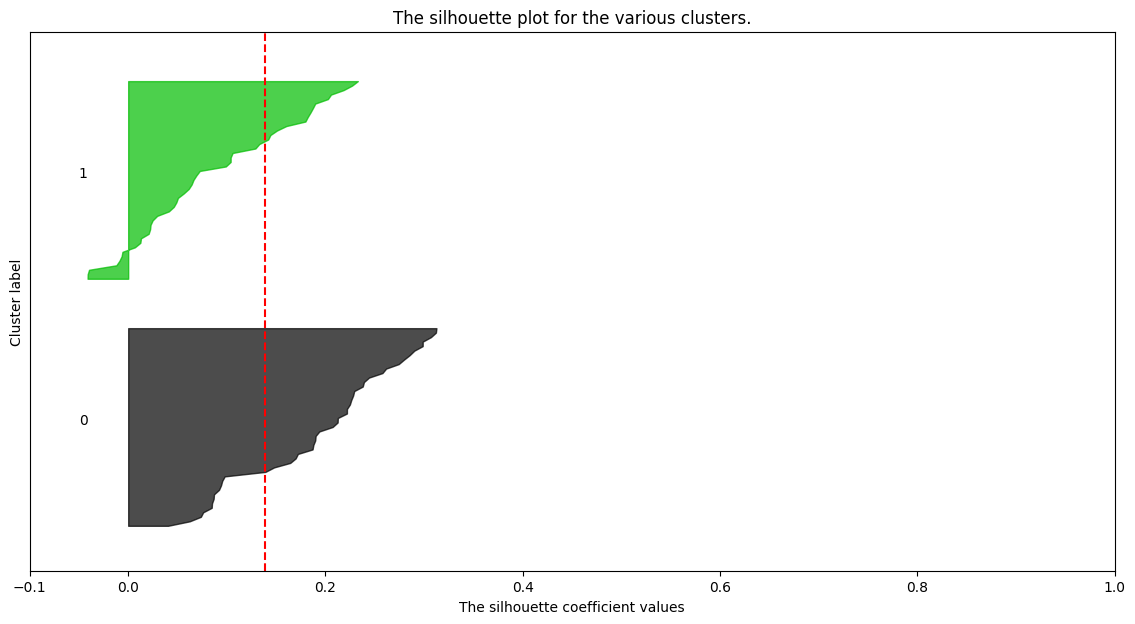

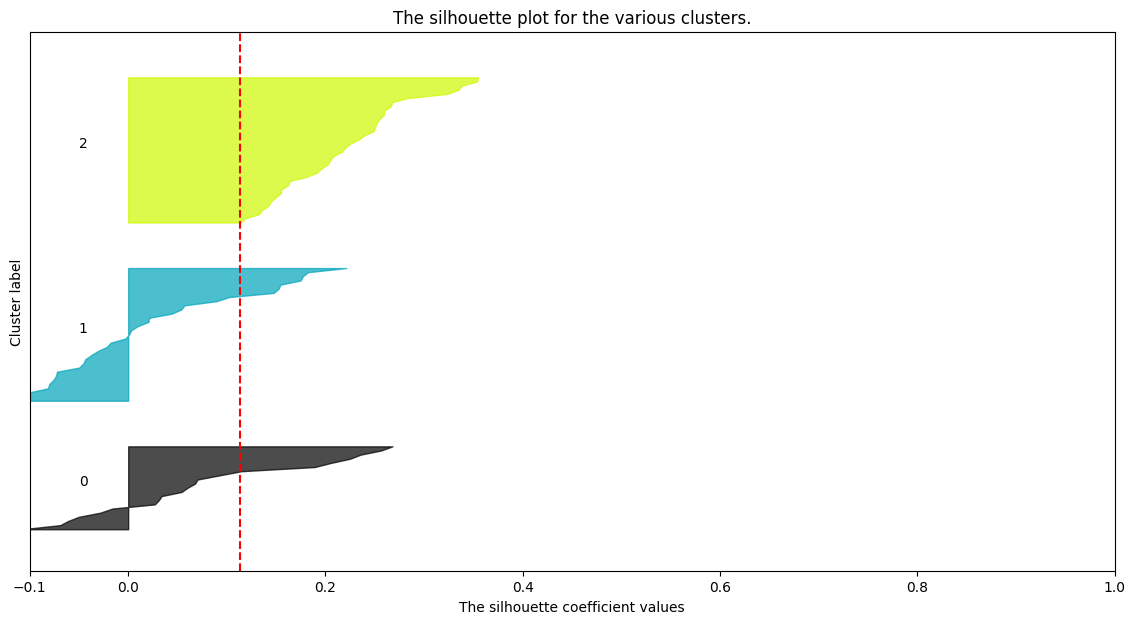

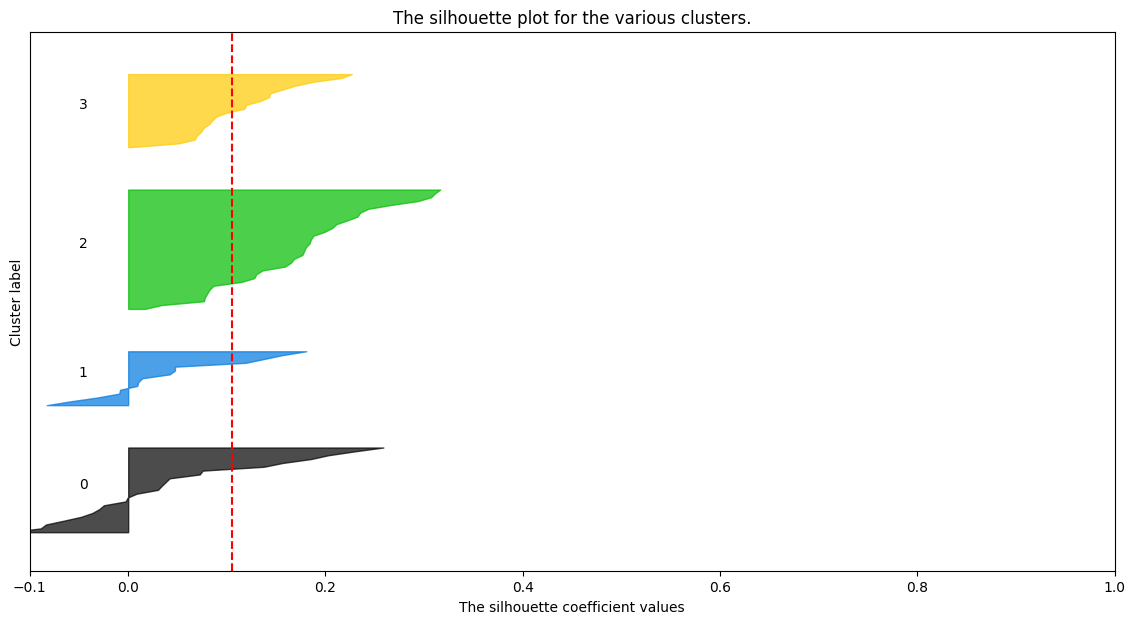

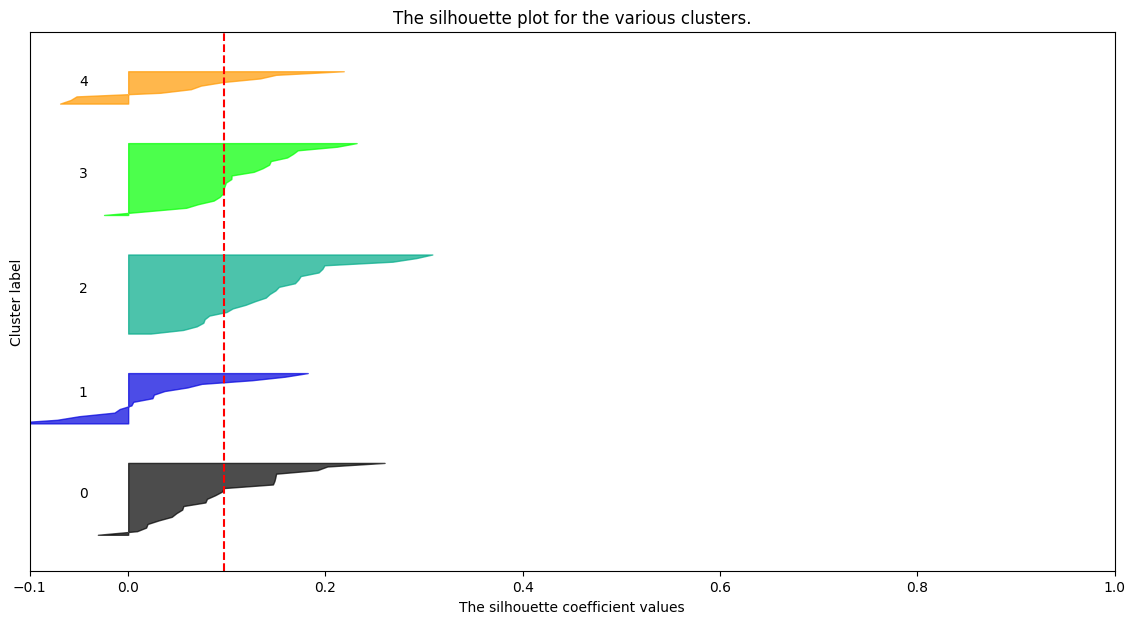

In [10]:
X = akuna_segmentation_data.to_numpy()
range_n_clusters = [2, 3, 4, 5]

for n_clusters in range_n_clusters:
    fig, ax = plt.subplots()
    fig.set_size_inches(14, 7)

    # Silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters,random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax.set_title("The silhouette plot for the various clusters.")
    ax.set_xlabel("The silhouette coefficient values")
    ax.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax.set_yticks([])  # Clear the yaxis labels / ticks
    ax.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

plt.show()

n Segments solution using K-Means

In [11]:
# Perform clustering with K=n, relabel cluster to [1,2,3, n], add cluster labels back to dataset and show first 8 rows
akuna_segmentation_data["SegmentKM"] = KMeans(n_clusters=3,random_state=42).fit(akuna_segmentation_data).labels_
akuna_segmentation_data["SegmentKM"] = akuna_segmentation_data["SegmentKM"] + 1
akuna_segmentation_data.head(8)

,Boot weight,Softness of material,Foot Fit,Durability,Brand Reputation,Ball control,Ease of fit,Color options,Quality Preference,SegmentKM
1,2.0,2.0,5.0,4.0,5.0,5.0,5.0,2.0,5.0,1
2,3.0,3.0,5.0,5.0,2.0,2.0,2.0,1.0,2.0,2
3,2.0,4.0,5.0,5.0,4.0,4.0,2.0,1.0,4.0,2
5,2.0,3.0,5.0,4.0,3.0,5.0,1.0,1.0,5.0,2
6,3.0,1.0,5.0,5.0,2.0,3.0,5.0,1.0,4.0,3
7,4.0,3.0,4.0,4.0,1.0,4.0,1.0,1.0,2.0,2
9,4.0,4.0,3.0,5.0,2.0,5.0,2.0,1.0,4.0,2
13,4.0,3.0,4.0,5.0,2.0,5.0,3.0,2.0,4.0,3


In [12]:
# Segment sizes 
akuna_segmentation_data_Sizes = pd.DataFrame(akuna_segmentation_data.groupby("SegmentKM").size(),columns=["Size"]).T
akuna_segmentation_data_Sizes.insert(0,"Population",len(akuna_segmentation_data))
akuna_segmentation_data_Sizes.loc["%"] = akuna_segmentation_data_Sizes.iloc[0].div(akuna_segmentation_data_Sizes.iloc[0,0]).mul(100).astype(int)
akuna_segmentation_data_Sizes

SegmentKM,Population,1,2,3
Size,90,20,45,25
%,100,22,50,27


Segments description

In [13]:
akuna_segmentation_data_Means = akuna_segmentation_data.groupby("SegmentKM").mean().T
akuna_segmentation_data_Means.insert(0,"Population",akuna_segmentation_data.drop(columns="SegmentKM").mean())
akuna_segmentation_data_Means.round(2)

SegmentKM,Population,1,2,3
Boot weight,2.98,3.35,2.76,3.08
Softness of material,3.90,4.25,3.73,3.92
Foot Fit,4.49,4.70,4.47,4.36
Durability,4.14,4.35,4.16,3.96
Brand Reputation,2.40,3.70,2.07,1.96
Ball control,3.89,4.55,3.67,3.76
Ease of fit,2.41,2.95,1.47,3.68
Color options,1.93,3.15,1.36,2.00
Quality Preference,3.77,4.50,3.31,4.00


In [14]:
# Significance of means differences between each segment and the rest of the population
# Using appropriate t-test imported from scipy or statsmodel package and setting colors using DataFrame’s style attribute
from scipy import stats
#from statsmodels.stats import weightstats as st

X = akuna_segmentation_data.copy()

def style_cols(col):
    if col.name == "Population": return ["background-color: white"]*len(col)
    
    segment = X[X.SegmentKM == col.name]
    rest_pop = X[X.SegmentKM != col.name]
    
    colors = []
    for var_name, var_segment_mean in col.items():
        t_test, p_value = stats.ttest_ind(segment[var_name], rest_pop[var_name],equal_var=False)
        #_,p_value,_ = st.ttest_ind(segment[var_name],rest_pop[var_name],usevar="unequal")    
        if p_value < 0.05:
            color = "background-color: green" if var_segment_mean > rest_pop[var_name].mean() else "background-color: red"
        elif p_value < 0.1:
            color = "background-color: #90ee90" if var_segment_mean > rest_pop[var_name].mean() else "background-color: #f1807e"
        else: color = "background-color: white"
        colors.append(color)
    return colors

akuna_segmentation_data_Means.style.apply(style_cols).format("{:.2f}")

SegmentKM,Population,1,2,3
Boot weight,2.98,3.35,2.76,3.08
Softness of material,3.90,4.25,3.73,3.92
Foot Fit,4.49,4.70,4.47,4.36
Durability,4.14,4.35,4.16,3.96
Brand Reputation,2.40,3.70,2.07,1.96
Ball control,3.89,4.55,3.67,3.76
Ease of fit,2.41,2.95,1.47,3.68
Color options,1.93,3.15,1.36,2.00
Quality Preference,3.77,4.50,3.31,4.00


Segmentation space using PCA (with pca package)

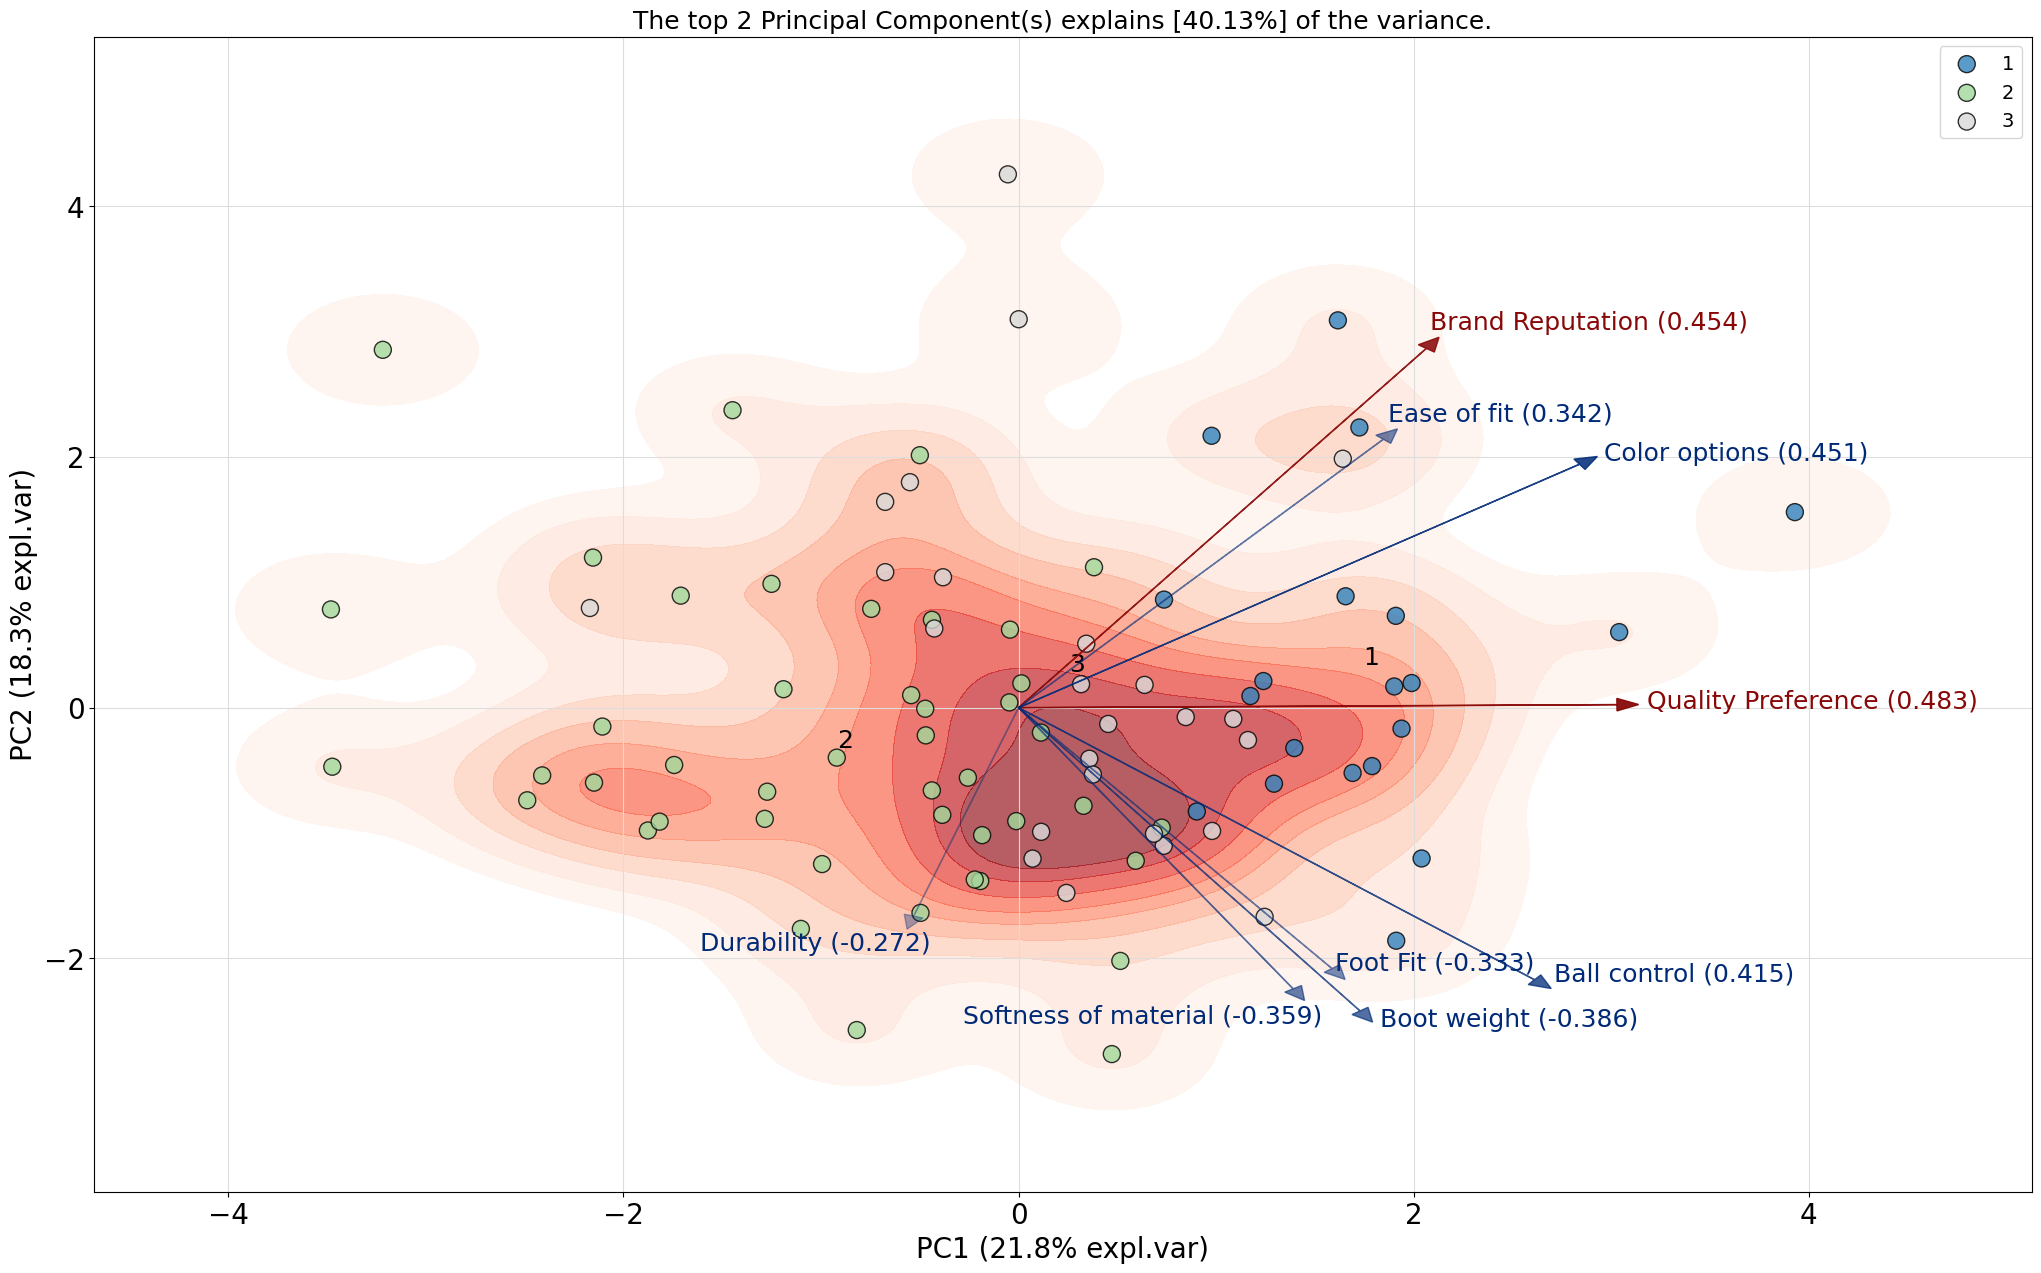

In [16]:
model = pca(n_components=2,normalize=True)
features = akuna_segmentation_data.drop(columns="SegmentKM")
segments = akuna_segmentation_data.SegmentKM

# Fit transform
results = model.fit_transform(features,verbose=False)
# Make biplot with the number of features
# Strenght of the loadings are shown in two colors (red=strong, blue=weak)
fig, ax = model.biplot(labels=segments,verbose=0,density=True);

n Segments solution using Hierarchical Clustering

In [18]:
hc = AgglomerativeClustering(n_clusters = 3,linkage="ward")
hc.fit(akuna_segmentation_data)

akuna_segmentation_data["SegmentHC"] = hc.labels_ + 1
akuna_segmentation_data.head(8)

,Boot weight,Softness of material,Foot Fit,Durability,Brand Reputation,Ball control,Ease of fit,Color options,Quality Preference,SegmentKM,SegmentHC
1,2.0,2.0,5.0,4.0,5.0,5.0,5.0,2.0,5.0,1,2
2,3.0,3.0,5.0,5.0,2.0,2.0,2.0,1.0,2.0,2,3
3,2.0,4.0,5.0,5.0,4.0,4.0,2.0,1.0,4.0,2,3
5,2.0,3.0,5.0,4.0,3.0,5.0,1.0,1.0,5.0,2,3
6,3.0,1.0,5.0,5.0,2.0,3.0,5.0,1.0,4.0,3,1
7,4.0,3.0,4.0,4.0,1.0,4.0,1.0,1.0,2.0,2,3
9,4.0,4.0,3.0,5.0,2.0,5.0,2.0,1.0,4.0,2,1
13,4.0,3.0,4.0,5.0,2.0,5.0,3.0,2.0,4.0,3,1


In [19]:
(akuna_segmentation_data.groupby("SegmentKM")["SegmentHC"].nunique()==1).all() and \
(akuna_segmentation_data.groupby("SegmentHC")["SegmentKM"].nunique()==1).all()

False

Segments sizes

In [20]:
akuna_segmentation_data_SizesHC = pd.DataFrame(akuna_segmentation_data.groupby("SegmentHC").size(),columns=["Size"]).T
akuna_segmentation_data_SizesHC.insert(0,"Population",len(akuna_segmentation_data))
akuna_segmentation_data_SizesHC.loc["%"] = akuna_segmentation_data_SizesHC.iloc[0].div(akuna_segmentation_data_SizesHC.iloc[0,0]).mul(100).astype(int)
akuna_segmentation_data_SizesHC

SegmentHC,Population,1,2,3
Size,90,31,19,40
%,100,34,21,44


Dendrogram (Ward method) using scipy package

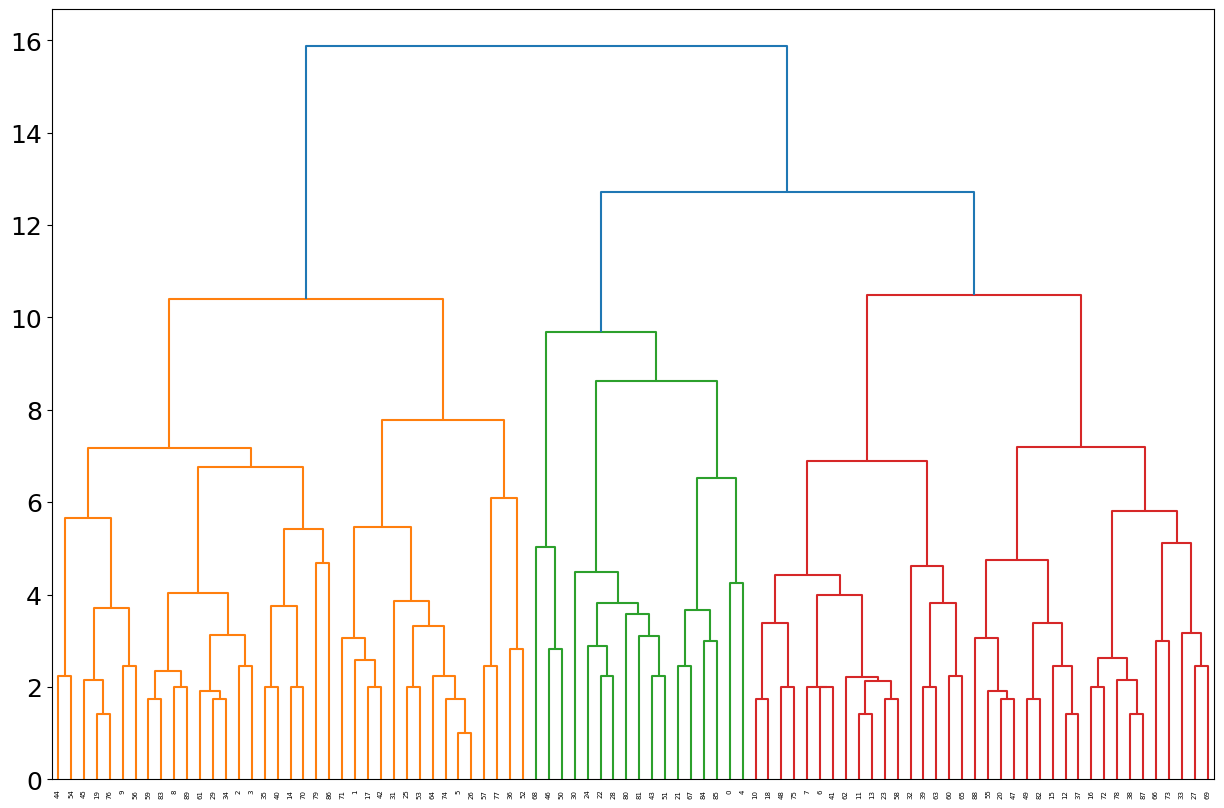

In [21]:
X = akuna_segmentation_data.drop(columns=["SegmentKM","SegmentHC"])

# Plot the hierarchical clustering as a dendrogram.
tree = hierarchy.linkage(X,'ward')
plt.figure(figsize=(15,10))
dn = hierarchy.dendrogram(tree)

Descriptor Analysis
Import Descriptor Data and add segment labels

In [ ]:
akuna_descriptor_data["SegmentKM"] = akuna_segmentation_data["SegmentKM"]
print("DataFrame: akuna_descriptor_data (with 'SegmentKM' column added)")
akuna_descriptor_data.head(8)


Segment description

In [ ]:
# Means of descriptor variables by segment
akuna_descriptor_data_Means = akuna_descriptor_data.groupby("SegmentKM").mean().T
akuna_descriptor_data_Means.insert(0,"Population",akuna_descriptor_data.drop(columns="SegmentKM").mean())
akuna_descriptor_data_Means.round(1)

In [ ]:
# Significance of means differences
from scipy import stats

def style_cols(col):
    if col.name == "Population": return ["background-color: white"]*len(col)
    
    segment_data = akuna_descriptor_data[akuna_descriptor_data["SegmentKM"] == col.name]
    rest_pop_data = akuna_descriptor_data[akuna_descriptor_data["SegmentKM"] != col.name]
    
    colors = []
    for var, var_segment_mean in col.iteritems():
        _, p_value = stats.ttest_ind(segment_data[var], rest_pop_data[var],equal_var=False)
        if p_value < 0.05:
            color = "background-color: green" if var_segment_mean > rest_pop_data[var].mean() else "background-color: red"
        elif p_value < 0.1:
            color = "background-color: #90ee90" if var_segment_mean > rest_pop_data[var].mean() else "background-color: #f1807e"
        else: color = "background-color: white"
        colors.append(color)
    return colors

akuna_descriptor_data_Means.style.apply(style_cols).format("{:.1f}")

Descriptor Space using PCA (with pca package)

In [ ]:
# Produce a PCA Biplot (i.e. PCA plot + Loadings plot) also featuring kernel densities using the pca package (documentation available at https://erdogant.github.io/pca)
import logging, sys
logging.disable(sys.maxsize)

#https://erdogant.github.io/pca
from pca import pca
model = pca(n_components=2,normalize=True)

features = akuna_descriptor_data.drop(columns="SegmentKM")
segments = akuna_descriptor_data.SegmentKM

# Fit transform
results = model.fit_transform(features,verbose=False)
# Make biplot with the number of features
# Strenght of the loadings are shown in two colors (red=strong, blue=weak)
fig, ax = model.biplot(labels=segments,verbose=0,density=True);

Classification model

In [ ]:
smf.mnlogit(formula="SegmentKM ~ professional + income + age",data=akuna_descriptor_data).fit().summary()

In [ ]:
PredTable = smf.mnlogit(formula="SegmentKM ~ professional + income + age",data=akuna_descriptor_data).fit().pred_table()

ConfusionMatrixDisplay(confusion_matrix=PredTable).plot();

Classification using Random Forest Classifier (from sklearn package)

In [3]:
X = akuna_descriptor_data.drop(columns="SegmentKM")
y = akuna_descriptor_data.SegmentKM

rf = RandomForestClassifier(n_estimators = 30,random_state = 42)
rf.fit(X, y)


NameError: name 'akuna_descriptor_data' is not defined

In [ ]:

# Feature importance (values and barplot)
importances = pd.DataFrame([rf.feature_importances_],columns=X.columns,index=["Importance"])
importances.round(2)

importances.plot.bar(xticks=[]);